# Final Project - Security Analytics
## Microsoft Malware Classfication

### Authors: 
* Kandarp Khandwala (kkhandw1) and 
* Antara Sargam (asargam1)


### Data: 
* Set of known malware files representing a mix of 9 different families. Each malware file has an Id, a 20 character hash value uniquely identifying the file, and a Class, an integer representing one of 9 family names to which the malware may belong 
        Ramnit
        Lollipop
        Kelihos_ver3
        Vundo
        Simda
        Tracur
        Kelihos_ver1
        Obfuscator.ACY
        Gatak
        

### Tasks: 
* Develop the best mechanism for classifying files into their respective family affiliations.

### Files
* train.7z - the raw data for the data set
* trainLabels.csv - the class labels associated with the training set

In [1]:
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import zipfile
from io import BytesIO
import lief 
import hashlib
import pandas as pd
import numpy as np
import os
import pickle
import io
import re
import glob

import lightgbm as lgb
from sklearn.metrics import log_loss, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from sklearn.feature_extraction import FeatureHasher
from sklearn import metrics

In [2]:
datadir = '/datadrive/'
traindir = 'train/'
asmext = '.asm'
byext = '.bytes'

In [3]:
dt = np.dtype([('Id', 'a30'), ('Class', 'u2')])
data = np.loadtxt("trainLabels.csv", skiprows=1, delimiter = ",", dtype=dt)

In [4]:
data

array([(b'"01kcPWA9K2BOxQeS5Rju"', 1), (b'"04EjIdbPV5e1XroFOpiN"', 1),
       (b'"05EeG39MTRrI6VY21DPd"', 1), (b'"05rJTUWYAKNegBk2wE8X"', 1),
       (b'"0AnoOZDNbPXIr2MRBSCJ"', 1), (b'"0AwWs42SUQ19mI7eDcTC"', 1),
       (b'"0cH8YeO15ZywEhPrJvmj"', 1), (b'"0DNVFKwYlcjO7bTfJ5p1"', 1),
       (b'"0DqUX5rkg3IbMY6BLGCE"', 1), (b'"0eaNKwluUmkYdIvZ923c"', 1),
       (b'"0fHVZKeTE6iRb1PIQ4au"', 1), (b'"0G4hwobLuAzvl1PWYfmd"', 1),
       (b'"0gkj92oIleU4SYiCWpaM"', 1), (b'"0H63jydvIahOVqgx5Kfo"', 1),
       (b'"0Hrfce4X5YGESJPjl9uL"', 1), (b'"0I4ZVvngsAatm8fzD3pk"', 1),
       (b'"0iBaz3krsQ8HuA7cGDSt"', 1), (b'"0iS3pwlgJco8XORD4TLq"', 1),
       (b'"0jkmvR43UQ9yKxqXei61"', 1), (b'"0KigmP9TLwJXNGz26tfO"', 1),
       (b'"0l6fhCty3aSLDOgAjYQi"', 1), (b'"0MOorvEIRmZGhqQdc3TA"', 1),
       (b'"0NEsQlDGnUMg3Bew7R1A"', 1), (b'"0NyfGXt8nmlK72Q9Irhs"', 1),
       (b'"0odUVkrjp2B1n8NDS6bR"', 1), (b'"0pTO4SVnWDehgUlYBAvq"', 1),
       (b'"0qpMX5CZU8mgD2kaRNVv"', 1), (b'"0Rgetc1wAfxlzHTGBOa7"', 1),
      

In [5]:
X = np.zeros((data.shape[0], 4))
y = data['Class']

# Feature Extraction

### Feature 1 - File size

In [6]:
for i, (Id, Class) in enumerate(data):
    X[i][0] = os.path.getsize(datadir + traindir + Id[1:-1].decode("utf-8") + asmext)
    X[i][1] = os.path.getsize(datadir + traindir + Id[1:-1].decode("utf-8") + byext)

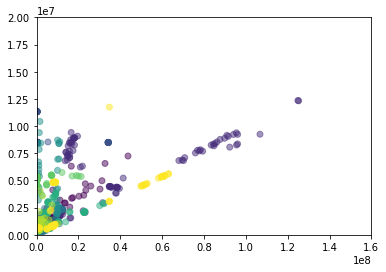

In [7]:
plt.axis((0,1.6*10**8, 0, 2*10**7))
plt.scatter(X[:,0], X[:,1], c=y, alpha=0.5)
plt.show()

### Feature 2 - Compressed File Size

In [8]:
def getcompressedsize(fpath):
    inMemoryOutputFile = BytesIO()
    zf = zipfile.ZipFile(inMemoryOutputFile, 'w') 
    zf.write(fpath, compress_type=zipfile.ZIP_DEFLATED)
    s = float(zf.infolist()[0].compress_size)
    zf.close()
    return s

In [15]:
for i, (Id, Class) in enumerate(data):
    print("Processed file {}".format(i))
    X[i][2] = getcompressedsize(datadir + traindir + Id[1:-1].decode("utf-8") + asmext)
    X[i][3] = getcompressedsize(datadir + traindir + Id[1:-1].decode("utf-8") + asmext)

Processed file 0
Processed file 1
Processed file 2
Processed file 3
Processed file 4
Processed file 5
Processed file 6
Processed file 7
Processed file 8
Processed file 9
Processed file 10
Processed file 11
Processed file 12
Processed file 13
Processed file 14
Processed file 15
Processed file 16
Processed file 17
Processed file 18
Processed file 19
Processed file 20
Processed file 21
Processed file 22
Processed file 23
Processed file 24
Processed file 25
Processed file 26
Processed file 27
Processed file 28
Processed file 29
Processed file 30
Processed file 31
Processed file 32
Processed file 33
Processed file 34
Processed file 35
Processed file 36
Processed file 37
Processed file 38
Processed file 39
Processed file 40
Processed file 41
Processed file 42
Processed file 43
Processed file 44
Processed file 45
Processed file 46
Processed file 47
Processed file 48
Processed file 49
Processed file 50
Processed file 51
Processed file 52
Processed file 53
Processed file 54
Processed file 55
Pr

Processed file 437
Processed file 438
Processed file 439
Processed file 440
Processed file 441
Processed file 442
Processed file 443
Processed file 444
Processed file 445
Processed file 446
Processed file 447
Processed file 448
Processed file 449
Processed file 450
Processed file 451
Processed file 452
Processed file 453
Processed file 454
Processed file 455
Processed file 456
Processed file 457
Processed file 458
Processed file 459
Processed file 460
Processed file 461
Processed file 462
Processed file 463
Processed file 464
Processed file 465
Processed file 466
Processed file 467
Processed file 468
Processed file 469
Processed file 470
Processed file 471
Processed file 472
Processed file 473
Processed file 474
Processed file 475
Processed file 476
Processed file 477
Processed file 478
Processed file 479
Processed file 480
Processed file 481
Processed file 482
Processed file 483
Processed file 484
Processed file 485
Processed file 486
Processed file 487
Processed file 488
Processed fi

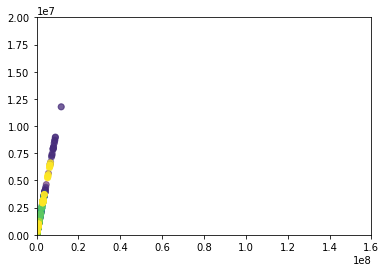

In [16]:
plt.axis((0,1.6*10**8, 0, 2*10**7))
plt.scatter(X[:,2], X[:,3], c=y, alpha=0.5)
plt.show()

### Feature 3 - TFIDF matrix of the contents of asm files over 2-gram

In [9]:
def make_corpus(asm_files):
    for i, file in enumerate(asm_files):
        print('Processed file {}'.format(i))
        yield open(file, 'rb')

In [10]:
import string
from nltk.corpus import stopwords
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char.decode("utf-8") for char in mess if char.decode("utf-8") not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.decode("utf-8").lower() not in stopwords.words('english')]


In [11]:
asmfiles = []
for i, (Id, Class) in enumerate(data):
    asmfiles.append(datadir + traindir + Id[1:-1].decode("utf-8") + asmext)

hv_transformer = HashingVectorizer(input='file', decode_error='replace',
                                      n_features=10000, stop_words='english',
                                      ngram_range=(2, 2))

In [12]:
asm_corpus = make_corpus(asmfiles)

In [13]:
asm_ngram = hv_transformer.transform(asm_corpus)

Processed file 0
Processed file 1
Processed file 2
Processed file 3
Processed file 4
Processed file 5
Processed file 6
Processed file 7
Processed file 8
Processed file 9
Processed file 10
Processed file 11
Processed file 12
Processed file 13
Processed file 14
Processed file 15
Processed file 16
Processed file 17
Processed file 18
Processed file 19
Processed file 20
Processed file 21
Processed file 22
Processed file 23
Processed file 24
Processed file 25
Processed file 26
Processed file 27
Processed file 28
Processed file 29
Processed file 30
Processed file 31
Processed file 32
Processed file 33
Processed file 34
Processed file 35
Processed file 36
Processed file 37
Processed file 38
Processed file 39
Processed file 40
Processed file 41
Processed file 42
Processed file 43
Processed file 44
Processed file 45
Processed file 46
Processed file 47
Processed file 48
Processed file 49
Processed file 50
Processed file 51
Processed file 52
Processed file 53
Processed file 54
Processed file 55
Pr

Processed file 438
Processed file 439
Processed file 440
Processed file 441
Processed file 442
Processed file 443
Processed file 444
Processed file 445
Processed file 446
Processed file 447
Processed file 448
Processed file 449
Processed file 450
Processed file 451
Processed file 452
Processed file 453
Processed file 454
Processed file 455
Processed file 456
Processed file 457
Processed file 458
Processed file 459
Processed file 460
Processed file 461
Processed file 462
Processed file 463
Processed file 464
Processed file 465
Processed file 466
Processed file 467
Processed file 468
Processed file 469
Processed file 470
Processed file 471
Processed file 472
Processed file 473
Processed file 474
Processed file 475
Processed file 476
Processed file 477
Processed file 478
Processed file 479
Processed file 480
Processed file 481
Processed file 482
Processed file 483
Processed file 484
Processed file 485
Processed file 486
Processed file 487
Processed file 488
Processed file 489
Processed fi

In [14]:
print('Shape of Sparse Matrix: ', asm_ngram.shape)
print('Amount of Non-Zero occurences: ', asm_ngram.nnz)
print('Sparsity: %.2f%%' % (100.0 * asm_ngram.nnz / (asm_ngram.shape[0] * asm_ngram.shape[1])))

Shape of Sparse Matrix:  (830, 10000)
Amount of Non-Zero occurences:  7678843
Sparsity: 92.52%


In [17]:
X = np.append(X, asm_ngram.toarray(), axis = 1)
X.shape

(830, 10004)

### Feature 4 -  String file characteristics: urls, directories, registries, headers, entropy, etc. 

In [18]:
class FeatureType(object):
    ''' Base class from which each feature type may inherit '''

    name = ''
    dim = 0

    def __repr__(self):
        return '{}({})'.format(self.name, self.dim)

    def raw_features(self, bytez, lief_binary):
        ''' Generate a JSON-able representation of the file '''
        raise (NotImplemented)

    def process_raw_features(self, raw_obj):
        ''' Generate a feature vector from the raw features '''
        raise (NotImplemented)

    def feature_vector(self, bytez, lief_binary):
        ''' Directly calculate the feature vector from the sample itself. This should only be implemented differently
        if there are significant speedups to be gained from combining the two functions. '''
        return self.process_raw_features(self.raw_features(bytez, lief_binary))

class StringExtractor(FeatureType):
    ''' Extracts strings from raw byte stream '''

    name = 'strings'
    dim = 1 + 1 + 1 + 96 + 1 + 1 + 1 + 1 + 1

    def __init__(self):
        super(FeatureType, self).__init__()
        # all consecutive runs of 0x20 - 0x7f that are 5+ characters
        self._allstrings = re.compile(b'[\x20-\x7f]{5,}')
        # occurances of the string 'C:\'.  Not actually extracting the path
        self._paths = re.compile(b'c:\\\\', re.IGNORECASE)
        # occurances of http:// or https://.  Not actually extracting the URLs
        self._urls = re.compile(b'https?://', re.IGNORECASE)
        # occurances of the string prefix HKEY_.  No actually extracting registry names
        self._registry = re.compile(b'HKEY_')
        # crude evidence of an MZ header (dropper?) somewhere in the byte stream
        self._mz = re.compile(b'MZ')

    def raw_features(self, bytez, lief_binary):
        allstrings = self._allstrings.findall(bytez)
        if allstrings:
            # statistics about strings:
            string_lengths = [len(s) for s in allstrings]
            avlength = sum(string_lengths) / len(string_lengths)
            # map printable characters 0x20 - 0x7f to an int array consisting of 0-95, inclusive
            as_shifted_string = [b - ord(b'\x20') for b in b''.join(allstrings)]
            c = np.bincount(as_shifted_string, minlength=96)  # histogram count
            # distribution of characters in printable strings
            csum = c.sum()
            p = c.astype(np.float32) / csum
            wh = np.where(c)[0]
            H = np.sum(-p[wh] * np.log2(p[wh]))  # entropy
        else:
            avlength = 0
            c = np.zeros((96,), dtype=np.float32)
            H = 0
            csum = 0

        return {
            'numstrings': len(allstrings),
            'avlength': avlength,
            'printabledist': c.tolist(),  # store non-normalized histogram
            'printables': int(csum),
            'entropy': float(H),
            'paths': len(self._paths.findall(bytez)),
            'urls': len(self._urls.findall(bytez)),
            'registry': len(self._registry.findall(bytez)),
            'MZ': len(self._mz.findall(bytez))
        }

    def process_raw_features(self, raw_obj):
        hist_divisor = float(raw_obj['printables']) if raw_obj['printables'] > 0 else 1.0
        return np.hstack([
            raw_obj['numstrings'], raw_obj['avlength'], raw_obj['printables'],
            np.asarray(raw_obj['printabledist']) / hist_divisor, raw_obj['entropy'], raw_obj['paths'], raw_obj['urls'],
            raw_obj['registry'], raw_obj['MZ']
        ]).astype(np.float32)


In [19]:
all_features = []
extractor = StringExtractor()
for i, (Id, Class) in enumerate(data):
    print("Processed file {}".format(i))
    file = datadir + traindir + Id[1:-1].decode("utf-8") + asmext
    with open(file, 'rb') as f:
        bytez = f.read()
        f.close()
    features = extractor.raw_features(bytez, None)
    all_features.append(extractor.process_raw_features(features))

string_features = np.array(all_features)

Processed file 0
Processed file 1
Processed file 2
Processed file 3
Processed file 4
Processed file 5
Processed file 6
Processed file 7
Processed file 8
Processed file 9
Processed file 10
Processed file 11
Processed file 12
Processed file 13
Processed file 14
Processed file 15
Processed file 16
Processed file 17
Processed file 18
Processed file 19
Processed file 20
Processed file 21
Processed file 22
Processed file 23
Processed file 24
Processed file 25
Processed file 26
Processed file 27
Processed file 28
Processed file 29
Processed file 30
Processed file 31
Processed file 32
Processed file 33
Processed file 34
Processed file 35
Processed file 36
Processed file 37
Processed file 38
Processed file 39
Processed file 40
Processed file 41
Processed file 42
Processed file 43
Processed file 44
Processed file 45
Processed file 46
Processed file 47
Processed file 48
Processed file 49
Processed file 50
Processed file 51
Processed file 52
Processed file 53
Processed file 54
Processed file 55
Pr

Processed file 438
Processed file 439
Processed file 440
Processed file 441
Processed file 442
Processed file 443
Processed file 444
Processed file 445
Processed file 446
Processed file 447
Processed file 448
Processed file 449
Processed file 450
Processed file 451
Processed file 452
Processed file 453
Processed file 454
Processed file 455
Processed file 456
Processed file 457
Processed file 458
Processed file 459
Processed file 460
Processed file 461
Processed file 462
Processed file 463
Processed file 464
Processed file 465
Processed file 466
Processed file 467
Processed file 468
Processed file 469
Processed file 470
Processed file 471
Processed file 472
Processed file 473
Processed file 474
Processed file 475
Processed file 476
Processed file 477
Processed file 478
Processed file 479
Processed file 480
Processed file 481
Processed file 482
Processed file 483
Processed file 484
Processed file 485
Processed file 486
Processed file 487
Processed file 488
Processed file 489
Processed fi

In [20]:
X = np.append(X, string_features, axis = 1)
X.shape

(830, 10108)

## Split into train and test

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(664, 10108) (664,)
(166, 10108) (166,)


## Run ExtraTreesClassifier on the Dataset
* The ExtraTreesClassifier is similar to RandomForestClassifier but cheaper to train from a computational point of view but can grow much bigger. We try this to get a quick overview of our results

In [30]:
et_clf = ExtraTreesClassifier(n_estimators=1000, max_features=None, min_samples_leaf=2,
        min_samples_split=9, n_jobs=8)

et_clf.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=9,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=8,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [31]:
y_prob = et_clf.predict_proba(X_test)
y_pred = et_clf.predict(X_test)
print("Predicted Values using ExtraTreesClassifier: {}".format(y_pred))
print("Predicted Probability using ExtraTreesClassifier: {}".format(y_prob))

Predicted Values using ExtraTreesClassifier: [8 9 1 1 8 8 8 2 9 2 9 8 6 4 3 3 3 3 3 4 2 4 3 1 8 7 7 9 3 9 1 8 8 3 2 2 8
 2 5 3 4 2 3 1 8 4 4 3 8 9 8 2 8 5 4 4 7 7 2 9 4 7 1 2 5 9 8 2 9 5 1 6 6 4
 9 2 7 5 1 7 8 8 1 3 8 1 2 4 8 1 8 2 3 1 8 5 1 3 9 6 2 6 4 3 4 6 5 7 2 2 7
 1 3 8 9 7 9 4 1 5 9 1 8 9 9 6 2 2 1 8 9 2 4 1 7 6 7 9 2 7 3 8 7 7 3 1 8 9
 4 1 7 7 3 3 8 9 1 2 7 4 8 9 2 9 1 3]
Predicted Probability using ExtraTreesClassifier: [[5.90250000e-02 9.30714286e-02 2.35583333e-02 ... 7.36988095e-02
  4.84141667e-01 9.12238095e-02]
 [2.44523810e-02 4.60142857e-02 1.45857143e-02 ... 5.66571429e-02
  4.27654762e-02 7.63301190e-01]
 [9.90214286e-01 6.42857143e-04 1.50000000e-03 ... 0.00000000e+00
  5.25000000e-03 5.00000000e-04]
 ...
 [1.37857143e-03 8.77142857e-03 0.00000000e+00 ... 3.60714286e-03
  1.02202381e-02 9.67739286e-01]
 [9.85708333e-01 1.00000000e-03 1.00000000e-03 ... 5.00000000e-04
  2.58333333e-03 1.00000000e-03]
 [0.00000000e+00 0.00000000e+00 9.99333333e-01 ... 0.00000000e+00
 

In [32]:
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)
print("Logarithmic Loss: {}".format(log_loss(y_test, y_prob, labels=[1, 2, 3, 4, 5, 6, 7, 8, 9])))

[[22  0  0  0  0  0  0  0  0]
 [ 0 22  0  0  0  0  0  0  0]
 [ 0  0 21  0  0  0  0  0  0]
 [ 0  0  0 17  0  0  0  0  0]
 [ 0  0  0  0  8  0  0  1  0]
 [ 0  0  0  0  0  8  0  1  1]
 [ 0  1  0  0  0  0 18  0  0]
 [ 0  0  0  0  0  0  0 25  0]
 [ 0  0  0  0  0  0  0  0 21]]
Logarithmic Loss: 0.1974372591212846


In [33]:
acc = metrics.accuracy_score(y_test, y_pred)
acc

0.9759036144578314

## Perform 5-fold cross validation

In [ ]:
y_pred = cross_val_predict(et_clf, X, y, cv=5)
print('Cross-validated predictions: ', y_pred)

In [ ]:
y_scores = cross_val_score(et_clf, X, y, cv=5, scoring='accuracy')
print('Cross-validated accuracy scores: ', y_scores)
print('Mean cross-validated accuracy scores: ', y_scores.mean())

## Run LightGBM on the Dataset
* Light GBM is a gradient boosting framework that uses tree based learning algorithm. It can handle the large size of our data and takes lower memory to run. Another reason of why Light GBM is popular is because it focuses on accuracy of results

In [22]:
y_train_lgb = y_train - 1 
y_train_lgb

array([5, 1, 8, 6, 5, 6, 3, 5, 6, 7, 5, 0, 8, 3, 5, 5, 3, 5, 8, 0, 7, 7,
       2, 3, 5, 7, 8, 8, 1, 2, 0, 3, 8, 7, 8, 7, 5, 2, 1, 0, 7, 2, 6, 8,
       1, 2, 7, 7, 1, 2, 3, 6, 6, 5, 2, 7, 5, 0, 0, 5, 1, 6, 2, 8, 0, 0,
       8, 3, 8, 5, 5, 5, 5, 5, 5, 7, 8, 6, 8, 7, 6, 7, 5, 5, 5, 8, 4, 6,
       4, 6, 4, 8, 2, 6, 8, 1, 2, 8, 1, 7, 2, 6, 5, 0, 7, 5, 8, 2, 3, 8,
       5, 5, 0, 6, 8, 1, 3, 1, 2, 1, 0, 5, 5, 8, 8, 6, 8, 7, 8, 2, 6, 6,
       3, 1, 6, 0, 5, 6, 2, 6, 3, 3, 3, 6, 7, 7, 6, 8, 2, 1, 1, 3, 2, 5,
       7, 3, 7, 2, 2, 6, 1, 1, 2, 4, 1, 2, 4, 2, 3, 0, 8, 8, 1, 3, 8, 6,
       3, 1, 8, 2, 3, 2, 8, 7, 5, 3, 0, 2, 1, 8, 3, 2, 5, 3, 6, 1, 2, 0,
       5, 2, 4, 2, 4, 1, 1, 3, 0, 7, 0, 0, 5, 8, 0, 1, 3, 7, 8, 0, 7, 3,
       1, 7, 6, 6, 5, 5, 3, 4, 6, 6, 0, 6, 5, 8, 6, 6, 1, 8, 7, 3, 2, 4,
       6, 0, 7, 6, 7, 1, 6, 6, 6, 2, 5, 2, 0, 8, 6, 2, 1, 7, 3, 3, 1, 4,
       1, 0, 8, 6, 7, 3, 0, 2, 0, 3, 8, 7, 1, 6, 5, 1, 8, 1, 5, 6, 8, 5,
       7, 7, 2, 5, 4, 6, 3, 0, 8, 3, 1, 0, 1, 7, 6,

In [23]:
d_train = lgb.Dataset(X_train, label=y_train_lgb)

params = {}
params['learning_rate'] = 0.5
params['boosting_type'] = 'dart'
params['objective'] = 'multiclass'
params['sub_feature'] = 0.5
params['num_leaves'] = 9
params['max_depth'] = 10
params['num_threads'] = 8
params['num_class'] = 9

In [24]:
lgb_clf = lgb.train(params, d_train, 100)

In [25]:
y_pred_lgb = lgb_clf.predict(X_test)
y_pred_lgb

array([[1.62734212e-03, 9.38167859e-03, 1.30916538e-03, ...,
        5.37584560e-04, 6.60378769e-01, 1.95662389e-03],
       [6.69295673e-07, 4.83557690e-06, 7.21938158e-07, ...,
        8.17149684e-06, 1.10066614e-06, 9.99955362e-01],
       [9.99989567e-01, 1.68352343e-06, 1.16839512e-07, ...,
        1.63885894e-07, 3.27106673e-06, 2.35642062e-06],
       ...,
       [8.78227480e-07, 1.02696220e-06, 9.73588357e-07, ...,
        1.39696752e-06, 1.24446020e-06, 9.99986084e-01],
       [9.99996176e-01, 1.91048586e-07, 1.86725899e-06, ...,
        9.11506816e-08, 3.64732846e-07, 7.59262774e-08],
       [4.10218878e-07, 2.26564681e-07, 9.99998622e-01, ...,
        1.86557717e-07, 1.72834668e-07, 2.13096634e-07]])

In [26]:
y_test_lgb = y_test - 1
y_test_lgb

array([7, 8, 0, 0, 7, 5, 4, 1, 8, 1, 8, 7, 5, 3, 2, 2, 2, 2, 2, 3, 1, 3,
       2, 0, 7, 6, 6, 8, 2, 8, 0, 7, 7, 2, 1, 1, 7, 1, 4, 2, 3, 1, 2, 0,
       7, 3, 3, 2, 7, 8, 7, 1, 7, 4, 3, 3, 6, 6, 1, 5, 3, 6, 0, 1, 4, 8,
       7, 6, 8, 4, 0, 5, 5, 3, 8, 1, 6, 4, 0, 6, 7, 7, 0, 2, 7, 0, 1, 3,
       7, 0, 7, 1, 2, 0, 7, 4, 0, 2, 8, 5, 1, 5, 3, 2, 3, 5, 4, 6, 1, 1,
       6, 0, 2, 7, 8, 6, 8, 3, 0, 4, 8, 0, 7, 8, 8, 5, 1, 1, 0, 7, 8, 1,
       3, 0, 6, 5, 6, 8, 1, 6, 2, 7, 6, 6, 2, 0, 7, 8, 3, 0, 6, 6, 2, 2,
       7, 8, 0, 1, 6, 3, 7, 8, 1, 8, 0, 2], dtype=uint16)

In [27]:
y_pred_lgb_best = np.array([np.argmax(line) for line in y_pred_lgb])
y_pred_lgb_best

array([7, 8, 0, 0, 7, 6, 4, 1, 8, 1, 8, 7, 5, 3, 2, 2, 2, 2, 2, 3, 1, 3,
       2, 0, 7, 6, 6, 8, 2, 8, 0, 7, 7, 2, 1, 1, 7, 1, 4, 2, 3, 1, 2, 0,
       7, 3, 3, 2, 7, 8, 7, 1, 7, 4, 3, 3, 6, 6, 1, 8, 3, 6, 0, 1, 4, 8,
       7, 6, 8, 4, 0, 5, 5, 3, 8, 1, 6, 4, 0, 6, 7, 7, 0, 2, 7, 0, 1, 3,
       7, 0, 7, 1, 2, 0, 5, 4, 0, 2, 8, 5, 1, 5, 3, 2, 3, 5, 5, 6, 1, 1,
       6, 0, 2, 7, 8, 6, 8, 3, 0, 4, 8, 0, 7, 8, 8, 5, 1, 1, 0, 7, 8, 1,
       3, 0, 6, 5, 6, 8, 1, 6, 2, 7, 6, 6, 2, 0, 7, 8, 3, 0, 6, 6, 2, 2,
       7, 8, 0, 1, 6, 3, 7, 8, 1, 8, 0, 2])

In [28]:
cm  = metrics.confusion_matrix(y_test_lgb, y_pred_lgb_best)
cm

array([[22,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 22,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 21,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 17,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  8,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  8,  1,  0,  1],
       [ 0,  0,  0,  0,  0,  0, 19,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0, 24,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 21]])

In [29]:
acc = metrics.accuracy_score(y_pred_lgb_best, y_test_lgb)
acc

0.9759036144578314